In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [3]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [4]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [7]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=True)(inputs_1)
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=False)(rnn)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1, 100)            14500     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 34,701
Trainable params: 34,701
Non-trainable params: 0
_________________________________________________________________


Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4740/4749 [============================>.] - ETA: 0s - loss: 112.4466
Epoch 00001: val_loss improved from inf to 111.05571, saving model to checkpoint.keras
4749/4749 [==============================] - 2s 321us/sample - loss: 112.4048 - val_loss: 111.0557
Epoch 2/200
4230/4749 [=========================>....] - ETA: 0s - loss: 93.1366
Epoch 00002: val_loss improved from 111.05571 to 98.49231, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 75us/sample - loss: 92.9566 - val_loss: 98.4923
Epoch 3/200
4410/4749 [==========================>...] - ETA: 0s - loss: 61.1490
Epoch 00003: val_loss improved from 98.49231 to 52.04737, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 97us/sample - loss: 59.8272 - val_loss: 52.0474
Epoch 4/200
4260/4749 [=========================>....] - ETA: 0s - loss: 37.5754
Epoch 00004: val_loss improved from 52.04737 to 33.99116, saving m

Epoch 33/200
4500/4749 [===========================>..] - ETA: 0s - loss: 20.0859
Epoch 00033: val_loss improved from 22.53276 to 22.50490, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 68us/sample - loss: 20.0664 - val_loss: 22.5049
Epoch 34/200
4680/4749 [============================>.] - ETA: 0s - loss: 20.0618
Epoch 00034: val_loss did not improve from 22.50490
4749/4749 [==============================] - 0s 76us/sample - loss: 20.0409 - val_loss: 22.5437
Epoch 35/200
4650/4749 [============================>.] - ETA: 0s - loss: 19.9860
Epoch 00035: val_loss improved from 22.50490 to 22.50067, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 67us/sample - loss: 20.0118 - val_loss: 22.5007
Epoch 36/200
4470/4749 [===========================>..] - ETA: 0s - loss: 19.9451
Epoch 00036: val_loss did not improve from 22.50067
4749/4749 [==============================] - 0s 67us/sample - loss: 19.9809 - val_loss: 22.5342
Ep

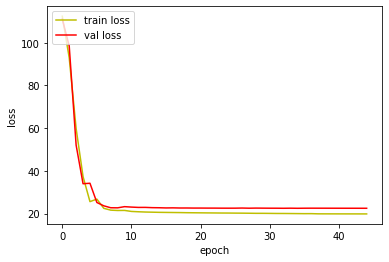

In [8]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  3.6558964161352634


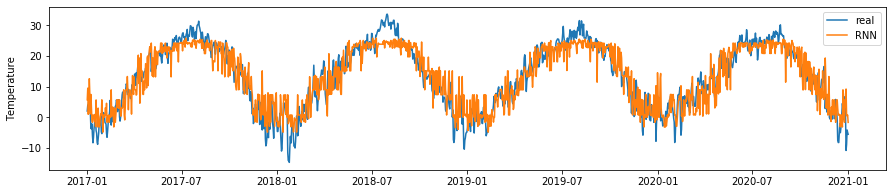

In [9]:
time = pd.to_datetime(test['일시'])

pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_RNN)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())

DNN으로 예측한 결과로 MAE를 계산했을 때, 2.x 정도 나왔다.  
RNN 결과는 3.x로 DNN보다 MAE도 낮고 그래프 상으로 보았을 때도 잘 예측하였다고 할 수 없다.  
여름과 겨울, 온도가 높아지고 낮아질 때 예측 정확도가 낮다.  
RNN을 잘못 쓰고 있는건 아닐까?

tf.keras.layers.SimpleRNN  레이어 설명을 보면 다음과 같다.  